# Generate animated simulation of genetic algo evolution

In [1]:
from deap import algorithms, base, creator, tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import json
import sys
import shutil
import os
from genetic_model import geneticModel
%matplotlib inline

In [2]:
modelConfig = {
    'populationSize': 230,
    'crossoverPB': 0.64,
    'mutationPB': 0.33,
    'nrGenerations': 308,
    'notImprovingLimit': 16,
    'keepHistory': True
}
p=40
i=2
timeLimit=9999
npzfile = np.load('./points/{}/{}.npz'.format(p,i))
distanceMatrix = npzfile['dist']
xTot = npzfile['xTot']
yTot = npzfile['yTot']

# update model configuration
modelConfig['distanceMatrix'] = distanceMatrix
modelConfig['individualSize'] = p
modelConfig['timeLimit'] = timeLimit

pop, logb, hof, generationLog = geneticModel(**modelConfig)

   Early stopping, no improvement for 16 iterations


In [3]:
# Create dir for temporary images
os.mkdir('./temp-img')

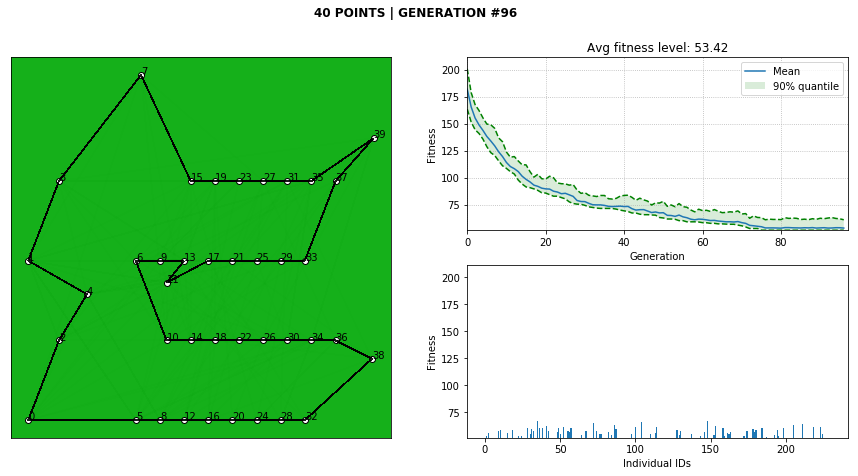

In [4]:
maxFitness = max([log['max'] for log in logb])
minFitness = min([log['min'] for log in logb])
fitnessHistory = {0.05: [], 0.95: [], 'avg': []}

fullGen = generationLog[:]

fig = plt.figure(figsize=(15,7))
for genID, gen in enumerate(fullGen):
    ax1 = plt.subplot2grid((2,2), (0,0), rowspan=2)
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,1))
    fig.suptitle('{} POINTS | GENERATION #{}'.format(p, genID), fontweight='bold')
    
    ax1.scatter(xTot, yTot, c='white', edgecolors='black')
    ax1.set_facecolor('xkcd:green')
    for i, l in enumerate(xTot):
        ax1.annotate(i, (xTot[i], yTot[i]))

    for ind in gen:
        verts = [(x,y) for x,y in zip(xTot[ind],yTot[ind])]
        verts.append(verts[0])
        #print(verts[0])
        codes = [Path.MOVETO] + [Path.LINETO]*(len(ind)-1) + [Path.CLOSEPOLY]
        path = Path(verts,codes)
        patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.002)
        ax1.add_patch(patch)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    # show fitness level
    fitnesses = [ind.fitness.values[0] for ind in gen]
    avgFitness = np.mean(fitnesses)
    fitnessQ = np.quantile(fitnesses, [0.05, 0.95])
    width = 0.25
    pos = list(range(len(gen)))
    ax3.bar([p + width for p in pos],fitnesses)
    ax3.set_ylim([minFitness, maxFitness])
    ax3.set_xlabel('Individual IDs')
    ax3.set_ylabel('Fitness')
    
    # show fitness history
    fitnessHistory[0.05].append(fitnessQ[0])
    fitnessHistory[0.95].append(fitnessQ[1])
    fitnessHistory['avg'].append(avgFitness)
    x = list(range(genID+1))
    ax2.plot(x, fitnessHistory['avg'], label='Mean')
    ax2.plot(x,fitnessHistory[0.05], linestyle='--', c='green')
    ax2.plot(x,fitnessHistory[0.95], linestyle='--', c='green')
    ax2.fill_between(x, fitnessHistory[0.05], fitnessHistory[0.95],
                     where=fitnessHistory[0.05] <= fitnessHistory[0.95],
                     facecolor='green', alpha=0.15, label='90% quantile')
    ax2.set_xlim([0,len(fullGen)])
    ax2.set_ylim([minFitness, maxFitness])
    ax2.set_ylabel('Fitness')
    ax2.set_xlabel('Generation')
    ax2.set_title('Avg fitness level: {}'.format(round(avgFitness, 2)))
    ax2.grid(linestyle='dotted')
    ax2.legend(loc='upper right')
    
    plt.savefig('./temp-img/{:03d}.jpg'.format(genID),bbox_inches='tight')
    # the last image is saved for reference
    if genID == len(fullGen)-1:
        plt.savefig('./{}.jpg'.format(genID),bbox_inches='tight')

In [5]:
# convert images to gif
os.system('convert -delay 20 -loop 0 ./temp-img/*.jpg genetic-animation.gif')

0

In [6]:
# remove images
shutil.rmtree('./temp-img')